# 0. Load Libraries

In [2]:
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import metacells as mc
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import seaborn as sb

from math import hypot
from matplotlib.collections import LineCollection
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('svg')
sb.set_style("white")

%load_ext autoreload
%autoreload 2

In [3]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

from matplotlib import rcParams
from matplotlib import colors

# Ignore R warning messages
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(6,6)
rcParams.update({'font.size': 12})
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100, dpi_save=300, facecolor='white')

In [4]:
%%R

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(Seurat)
library(scater)

# 1. Read data

In [87]:
inputF = '/mnt/data/Raw-from-paper/submission_210120.h5ad'

raw = ad.read_h5ad(inputF)
mc.ut.set_name(raw, 'Reynolds-2021')
print(raw.shape)

(451594, 33538)


In [88]:
del raw.var

In [6]:
use_celltype = ['Mono_mac','moDC_1','moDC_2','moDC_3','MigDC','DC1','DC2',
               'LC_1','LC_2','LC_3','LC_4','Macro_1','Macro_2','Inf_mac']

In [215]:
# Select AD patients only
raw_AD_myeloid = raw[(raw.obs['Status'] == "Eczema") &
                (raw.obs['Enrichment'] == "CD45P") &
                (raw.obs['full_clustering'].isin(use_celltype))].copy()

In [216]:
raw_AD_myeloid

AnnData object with n_obs × n_vars = 17111 × 33538
    obs: 'sample_id', 'mad_prd', 'Status', 'Site', 'Tissue', 'Enrichment', 'Location', 'Sex', 'Age', 'stage', 'full_clustering'
    uns: '__name__'

In [93]:
'FCGR1A' in raw.var_names

True

# 2. Cleaning data

In [217]:
full = raw_AD_myeloid

## 2.1 Cleaning genes

In [218]:
# exclude genes by names
excluded_gene_names = ['IGHMBP2', 'IGLL1', 'IGLL5', 'IGLON5', 'NEAT1', 'TMSB10', 'TMSB4X']
excluded_gene_patterns = ['MT-.*']

# also automatically remove 
# 1. genes by name and patterns
# 2. genes that have 0 total UMI (properly_sampled_gene; default is UMI>=1, you can specify other threshold)
# 3. genes which have a significant expression level but no significant correlation with any other gene (noisy_lonely_gene)

mc.pl.analyze_clean_genes(full,
      excluded_gene_names=excluded_gene_names,
      excluded_gene_patterns=excluded_gene_patterns,
      random_seed=10)

# the above function will add per-gene annotation for filtering later:
# excluded_gene, properly_sampled_gene, noisy_lonely_gene

# combine all these mask into a final clean_gene mask
mc.pl.pick_clean_genes(full)

set Reynolds-2021.var[properly_sampled_gene]: 21931 true (65.39%) out of 33538 bools
set Reynolds-2021.var[excluded_gene]: 20 true (0.05963%) out of 33538 bools
set Reynolds-2021.var[noisy_lonely_gene]: 1 true (0.002982%) out of 33538 bools
set Reynolds-2021.var[clean_gene]: 21911 true (65.33%) out of 33538 bools


## 2.2 Cleaning cells

> two criteria: 
> 1. the total number of UMIs for each cell
> 2. the fraction of these UMIs that come from excluded (non-clean) genes

### 2.2.1 Total number of UMIs for each cell

In [219]:
# calculate total UMIs
total_umis_of_cells = mc.ut.get_o_numpy(full, name='__x__', sum=True)

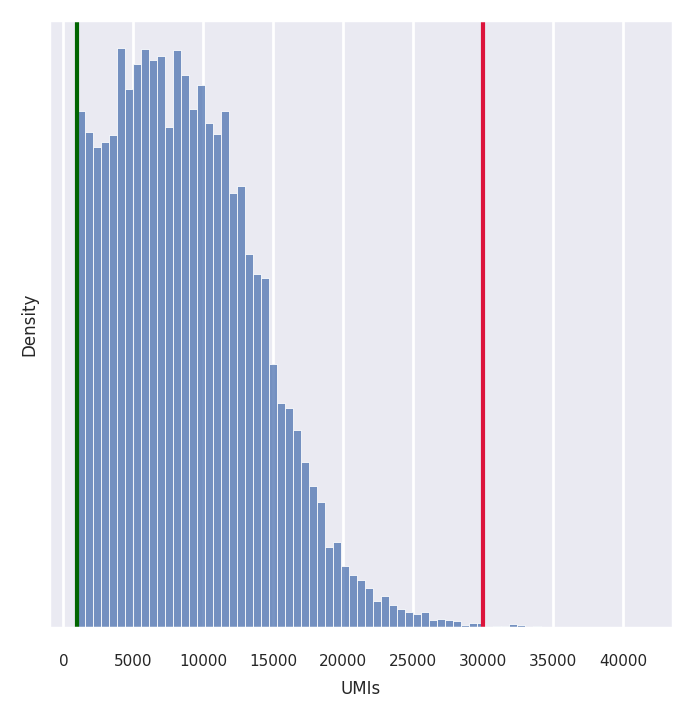

In [221]:
# make some plot
properly_sampled_min_cell_total = 1000
properly_sampled_max_cell_total = 30000

plot = sb.histplot(total_umis_of_cells)
plot.set(xlabel='UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_min_cell_total, color='darkgreen')
plot.axvline(x=properly_sampled_max_cell_total, color='crimson')
plt.show()

In [222]:
# get some statistics
too_small_cells_count = sum(total_umis_of_cells < properly_sampled_min_cell_total)
too_large_cells_count = sum(total_umis_of_cells > properly_sampled_max_cell_total)

too_small_cells_percent = 100.0 * too_small_cells_count / len(total_umis_of_cells)
too_large_cells_percent = 100.0 * too_large_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with less than %s UMIs"
      % (too_small_cells_count,
         too_small_cells_percent,
         properly_sampled_min_cell_total))
print(f"Will exclude %s (%.2f%%) cells with more than %s UMIs"
      % (too_large_cells_count,
         too_large_cells_percent,
         properly_sampled_max_cell_total))

Will exclude 0 (0.00%) cells with less than 1000 UMIs
Will exclude 23 (0.13%) cells with more than 30000 UMIs


### 2.2.2 Fraction of these UMIs that come from excluded (non-clean) genes

In [223]:
# calculate the fraction of UMIs coming from non-clean genes
excluded_genes_data = mc.tl.filter_data(full, var_masks=['~clean_gene'])[0]
excluded_umis_of_cells = mc.ut.get_o_numpy(excluded_genes_data, name='__x__', sum=True)
excluded_fraction_of_umis_of_cells = excluded_umis_of_cells / total_umis_of_cells

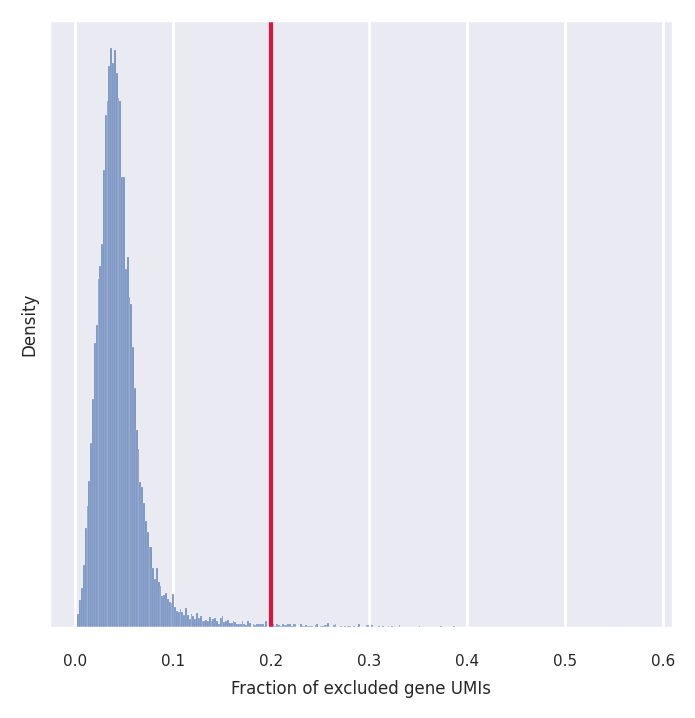

In [225]:
# make some plot
properly_sampled_max_excluded_genes_fraction = 0.2

plot = sb.histplot(excluded_fraction_of_umis_of_cells)
plot.set(xlabel='Fraction of excluded gene UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_max_excluded_genes_fraction, color='crimson')
plt.show()

In [226]:
# get some statistics
too_excluded_cells_count = sum(excluded_fraction_of_umis_of_cells > properly_sampled_max_excluded_genes_fraction)
too_excluded_cells_percent = 100.0 * too_excluded_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with more than %.2f%% excluded gene UMIs"
      % (too_excluded_cells_count,
         too_excluded_cells_percent,
         100.0 * properly_sampled_max_excluded_genes_fraction))

Will exclude 168 (0.98%) cells with more than 20.00% excluded gene UMIs


### 2.2.3 Automating clean cells
The above procedures provide calcuation / visualization for thresholds

In [227]:
# create per cell annotation (properly_sampled_cell)
mc.pl.analyze_clean_cells(
    full,
    properly_sampled_min_cell_total=properly_sampled_min_cell_total,
    properly_sampled_max_cell_total=properly_sampled_max_cell_total,
    properly_sampled_max_excluded_genes_fraction=properly_sampled_max_excluded_genes_fraction)

# create a clean_cell mask
mc.pl.pick_clean_cells(full)

set Reynolds-2021.obs[properly_sampled_cell]: 16920 true (98.88%) out of 17111 bools
set Reynolds-2021.obs[clean_cell]: 16920 true (98.88%) out of 17111 bools


## 2.3 Extracting the clean data
using the `clean_gene` and `clean_cell` masks

In [228]:
clean = mc.pl.extract_clean_data(full)

set Reynolds-2021.clean.obs[full_cell_index]: 16920 int64s
set Reynolds-2021.clean.var[full_gene_index]: 21911 int64s


# 3. Initial forbidden genes
> Some of the genes that are included in the clean data are “lateral”, that is, indicate some real biolgical behavior such as cell cycle, but are irrelevant to the biological questions we are interested in. Such genes shouldn’t be completely excluded - for example they are used to detect outliers. That is, we will still make sure the level of the expression of these genes is consistent for all the cells (e.g., the cells will be of the same cell cycle stage), but we do not want the algorithm to create metacells based on these genes (e.g., creating a metacell with a strong consistent S-state signature, but mixing up weakly different cell behaviors which we are trying to isolate).

These genes will NOT be used as “feature genes”

In [229]:
suspect_gene_names = ['PCNA', 'MKI67', 'TOP2A', 'HIST1H1D',
                      'FOS', 'JUN', 'HSP90AB1', 'HSPA1A',
                      'ISG15', 'WARS' ]
suspect_gene_patterns = [ 'MCM[0-9]', 'SMC[0-9]', 'IFI.*' ]

suspect_genes_mask = mc.tl.find_named_genes(clean, 
                                            names=suspect_gene_names,
                                            patterns=suspect_gene_patterns)
suspect_gene_names = sorted(clean.var_names[suspect_genes_mask])

In [230]:
# genes that are correlated with the suspect genes
# this function will identify gene modules
# Note relate_genes is a only quick-and-dirty way to group genes together
mc.pl.relate_genes(clean)

set Reynolds-2021.clean.var[related_genes_module]: 20010 outliers (91.32%) out of 21911 int32 elements with 112 groups with mean size 16.97
set Reynolds-2021.clean.varp[related_genes_similarity]: csr_matrix 21911 X 21911 float32s


In [231]:
# look at the genes within these gene modules
# identify modules that contained the above known suspect genes 
# (of course you should look at all the suspect modules beyond the ones containing known suspect genes)

module_of_genes = clean.var['related_genes_module']
suspect_gene_modules = np.unique(module_of_genes[suspect_genes_mask])
suspect_gene_modules = suspect_gene_modules[suspect_gene_modules >= 0]
print(suspect_gene_modules)

[ 15  21  26  33  40  51  55  56  74  80  84  91  96 105 111]


In [232]:
# get gene similarity matrix calculated from relate_genes
similarity_of_genes = mc.ut.get_vv_frame(clean, 'related_genes_similarity')

In [233]:
def mean_sim(sim_mat):
    # average similarity between each pair of genes
    n = len(sim_mat)
    n2 = (n**2-n)/2
    return np.triu(sim_mat, k=1).sum() / n2

def if_high_sim_module(module, threshold = 0.7):
    module_genes_mask = module_of_genes == module
    similarity_of_module = similarity_of_genes.loc[module_genes_mask, module_genes_mask]
    return mean_sim(similarity_of_module) >= threshold

# function to plot gene similarity from a module calculated by relate_genes
def plot_suspect_module(gene_module):
    module_genes_mask = module_of_genes == gene_module
    similarity_of_module = similarity_of_genes.loc[module_genes_mask, module_genes_mask]
    similarity_of_module.index = \
    similarity_of_module.columns = [
        '(*) ' + name if name in suspect_gene_names else name
        for name in similarity_of_module.index
    ]
    ax = plt.axes()
    g = sb.heatmap(similarity_of_module, vmin=0, vmax=1, ax=ax, cmap="YlGnBu")
    
    sb.set(font_scale=0.5)
    ax.set_title(f'Gene Module {gene_module}, mean similarity = {np.round(mean_sim(similarity_of_module),3)}')
    plt.show()

In [234]:
high_sim_module = [x for x in suspect_gene_modules if if_high_sim_module(x)]
print(high_sim_module)

[15, 21, 33, 40, 96]


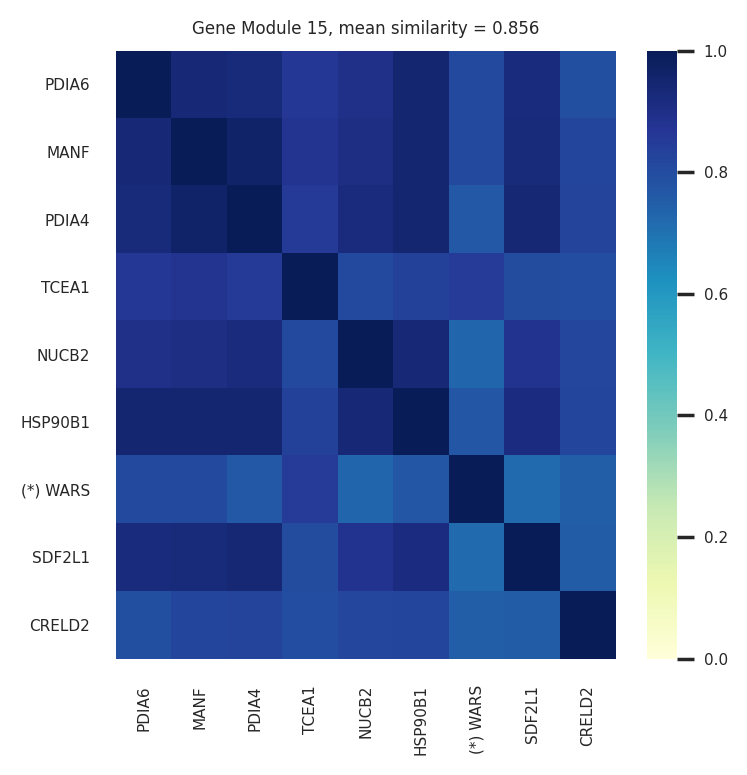

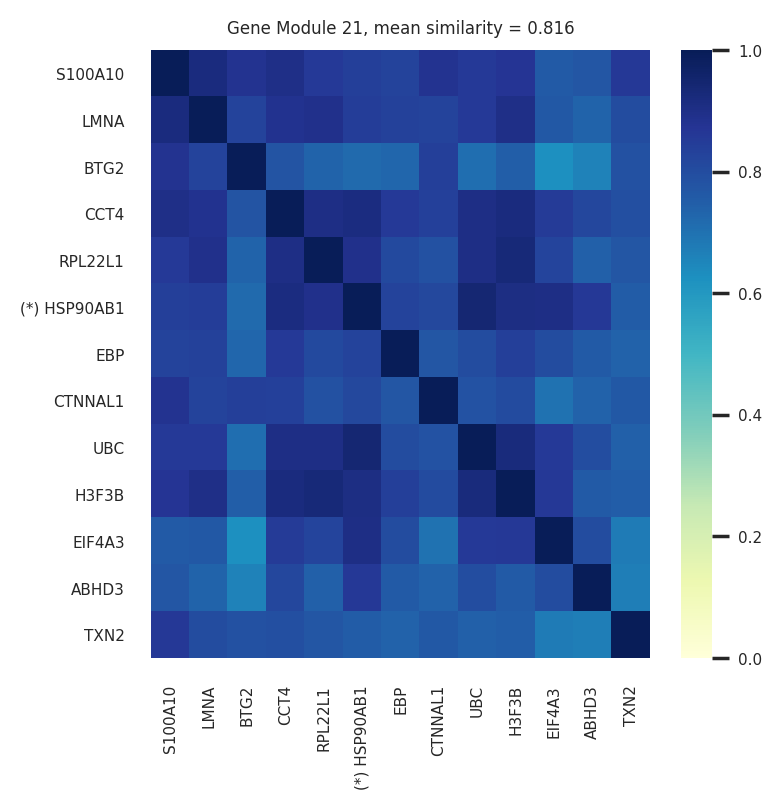

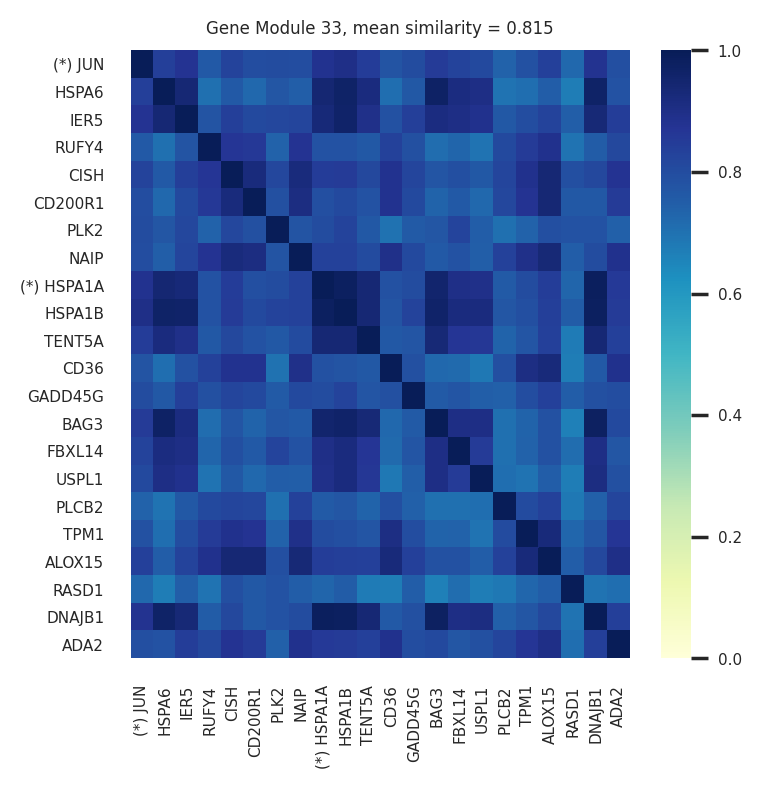

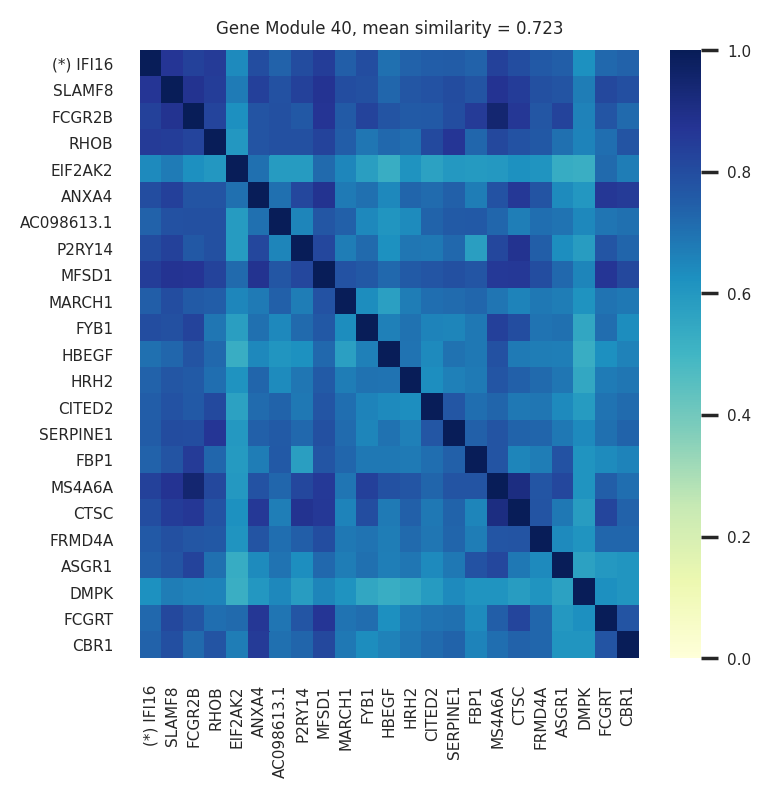

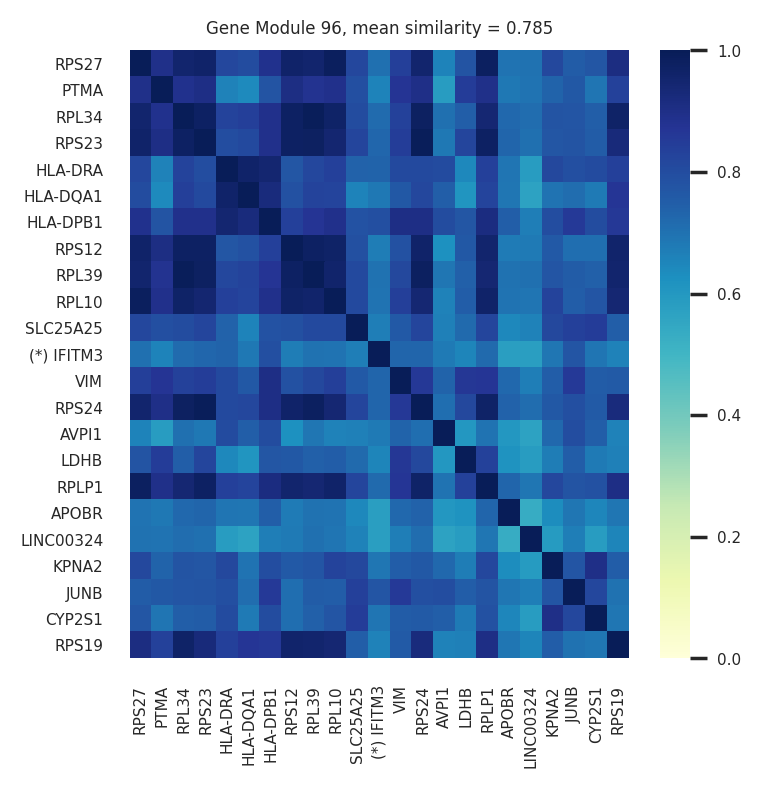

In [235]:
for m in high_sim_module:
    plot_suspect_module(m)

> We probably want to forbid genes with caution, since we expect the metacell analysis to help us expose any remaining genes we have missed. Here we only forbid the modules that strongly correlated with known suspect genes

In [236]:
forbidden_genes_mask = suspect_genes_mask
for gene_module in high_sim_module:
    module_genes_mask = module_of_genes == gene_module
    forbidden_genes_mask |= module_genes_mask
forbidden_gene_names = sorted(clean.var_names[forbidden_genes_mask])
print(len(forbidden_gene_names))
print(' '.join(forbidden_gene_names))

133
ABHD3 AC098613.1 ADA2 ALOX15 ANXA4 APOBR ASGR1 AVPI1 BAG3 BTG2 CBR1 CCT4 CD200R1 CD36 CISH CITED2 CRELD2 CTNNAL1 CTSC CYP2S1 DMPK DNAJB1 EBP EIF2AK2 EIF4A3 FBP1 FBXL14 FCGR2B FCGRT FOS FRMD4A FYB1 GADD45G H3F3B HBEGF HIST1H1D HLA-DPB1 HLA-DQA1 HLA-DRA HRH2 HSP90AB1 HSP90B1 HSPA1A HSPA1B HSPA6 IER5 IFI16 IFI27 IFI27L1 IFI27L2 IFI30 IFI35 IFI44 IFI44L IFI6 IFIH1 IFIT1 IFIT2 IFIT3 IFIT5 IFITM1 IFITM10 IFITM2 IFITM3 ISG15 JUN JUNB KPNA2 LDHB LINC00324 LMNA MANF MARCH1 MCM10 MCM2 MCM3 MCM3AP MCM3AP-AS1 MCM4 MCM5 MCM6 MCM7 MCM8 MCM8-AS1 MCM9 MFSD1 MKI67 MS4A6A NAIP NUCB2 P2RY14 PCNA PDIA4 PDIA6 PLCB2 PLK2 PTMA RASD1 RHOB RPL10 RPL22L1 RPL34 RPL39 RPLP1 RPS12 RPS19 RPS23 RPS24 RPS27 RUFY4 S100A10 SDF2L1 SERPINE1 SLAMF8 SLC25A25 SMC1A SMC1B SMC2 SMC2-AS1 SMC3 SMC4 SMC5 SMC5-AS1 SMC6 TCEA1 TENT5A TOP2A TPM1 TXN2 UBC USPL1 VIM WARS


# 4. Computing Metacells
* Use `mc.pl.set_max_parallel_piles` to control number of piles processed in parallel, because processing each pile takes a significant amount of memory
* Use `mc.pl.guess_max_parallel_piles` to guess a reasonable number of piles based on data and resources
* Use `target_metacell_size` to set target UMI for each metacell (default = 160k, the metacell number will be between 3/4 * 160k and 2 * 160k)

## 4.1 Running Metacells

### 4.1.1 Initial round of Metacells

In [237]:
def run_metacells(adata, forbidden_gene_names):
    max_parallel_piles = mc.pl.guess_max_parallel_piles(adata)
    mc.pl.set_max_parallel_piles(max_parallel_piles)
    mc.pl.divide_and_conquer_pipeline(adata,
                  forbidden_gene_names=forbidden_gene_names,
                  random_seed=10)

In [238]:
run_metacells(clean, forbidden_gene_names)

set Reynolds-2021.clean.var[rare_gene_module_0]: 11 true (0.0502%) out of 21911 bools
set Reynolds-2021.clean.var[rare_gene_module_1]: 18 true (0.08215%) out of 21911 bools
set Reynolds-2021.clean.var[rare_gene]: 29 true (0.1324%) out of 21911 bools
set Reynolds-2021.clean.obs[cells_rare_gene_module]: 16880 outliers (99.76%) out of 16920 int32 elements with 2 groups with mean size 20
set Reynolds-2021.clean.obs[rare_cell]: 40 true (0.2364%) out of 16920 bools
set Reynolds-2021.clean.uns[pre_directs]: 3
set Reynolds-2021.clean.uns[directs]: 5
set Reynolds-2021.clean.var[pre_high_total_gene]: 8835 positive (40.32%) out of 21911 int32s
set Reynolds-2021.clean.var[high_total_gene]: 9202 positive (42%) out of 21911 int32s
set Reynolds-2021.clean.var[pre_high_relative_variance_gene]: 4583 positive (20.92%) out of 21911 int32s
set Reynolds-2021.clean.var[high_relative_variance_gene]: 5096 positive (23.26%) out of 21911 int32s
set Reynolds-2021.clean.var[forbidden_gene]: 133 true (0.607%) out 

> This has written many annotations for each cell, the most important one is `metacell`

In [271]:
metacells = mc.pl.collect_metacells(clean)

set metacells.var[excluded_gene]: 0 true (0%) out of 21911 bools
set metacells.var[clean_gene]: 21911 true (100%) out of 21911 bools
set metacells.var[forbidden_gene]: 133 true (0.607%) out of 21911 bools
set metacells.var[pre_feature_gene]: 942 positive (4.299%) out of 21911 int32s
set metacells.var[feature_gene]: 1045 positive (4.769%) out of 21911 int32s
set metacells.obs[pile]: 820 int32s
set metacells.obs[candidate]: 820 int32s


## 4.2 Visualization

<a id ='4.2.1'></a>
### 4.2.1 Projecting on UMAP

In [272]:
# use min_dist to control how tight the points packed together
mc.pl.compute_umap_by_features(metacells, 
                               max_top_feature_genes=1000,
                               min_dist=0.5, random_seed=10)

set metacells.var[top_feature_gene]: 708 true (3.231%) out of 21911 bools
set metacells.obsp[obs_balanced_ranks]: 9446 nonzero (1.405%) out of 672400 elements
set metacells.obsp[obs_pruned_ranks]: 3260 nonzero (0.4848%) out of 672400 elements
set metacells.obsp[obs_outgoing_weights]: 3260 nonzero (0.4848%) out of 672400 elements
/opt/conda/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(
set metacells.obs[umap_x]: 820 float32s
set metacells.obs[umap_y]: 820 float32s


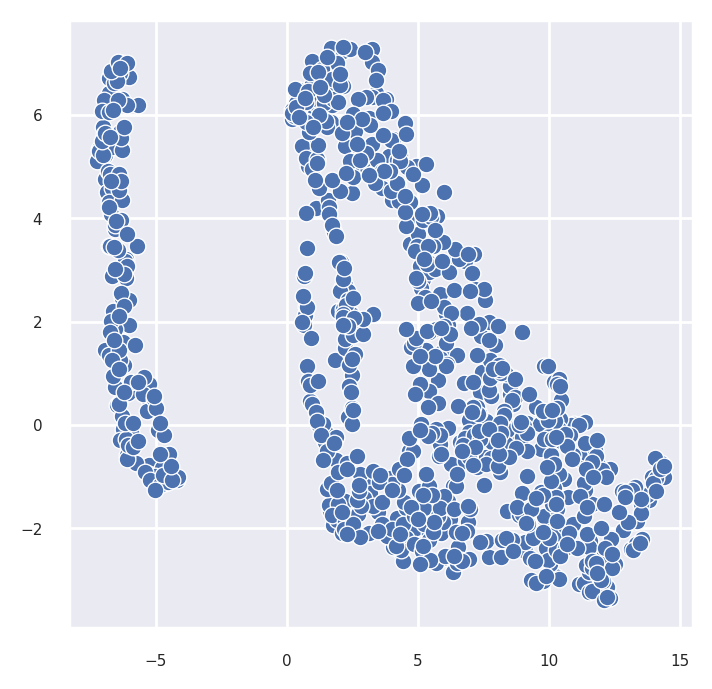

In [273]:
umap_x = mc.ut.get_o_numpy(metacells, 'umap_x')
umap_y = mc.ut.get_o_numpy(metacells, 'umap_y')
plot = sb.scatterplot(x=umap_x, y=umap_y)
plt.show()

### 4.2.2 Annotate Metacells with metatype based on the cell type of majority of cells in the Metacell
> do we need to weight on the total number of cells?
* Require that >50% of the cells within a metacell to be the same cell type

In [274]:
# get percentage of celltype per metacell
clean_celltype = clean.obs.groupby(['metacell','full_clustering']).size().unstack(fill_value = 0).rename_axis(None).rename_axis(None, axis = 1)

# first noramlize by the total number of the cell type
clean_celltype_pct = clean_celltype.div(clean_celltype.sum(axis = 0), axis = 1)
clean_celltype_pct = clean_celltype_pct.div(clean_celltype_pct.sum(axis = 1), axis = 0)
clean_celltype_pct.index = clean_celltype_pct.index.astype(str)

In [275]:
# merge metacell metadata with the above percentage
metacells.obs = pd.merge(metacells.obs, clean_celltype_pct, left_index = True, right_index = True, how = 'left')

metacells.obs['meta_type'] = metacells.obs[use_celltype].idxmax(axis = 1)
metacells.obs['meta_type_pct'] = metacells.obs[use_celltype].max(axis = 1)
metacells.obs['meta_type'] = metacells.obs.apply(lambda x: x['meta_type'] if x['meta_type_pct'] > 0.5 else 'Uncertain', axis = 1)

In [276]:
metacells.obs['meta_type'].value_counts()

Inf_mac      150
DC2          135
Uncertain     81
LC_3          55
moDC_1        52
Mono_mac      52
MigDC         43
Macro_1       42
DC1           39
LC_1          38
LC_2          36
Macro_2       30
moDC_2        30
moDC_3        20
LC_4          17
Name: meta_type, dtype: int64

In [277]:
# clean up uncertain and rare metacells
metacells = metacells[~metacells.obs['meta_type'].isin(['Uncertain'])].copy()

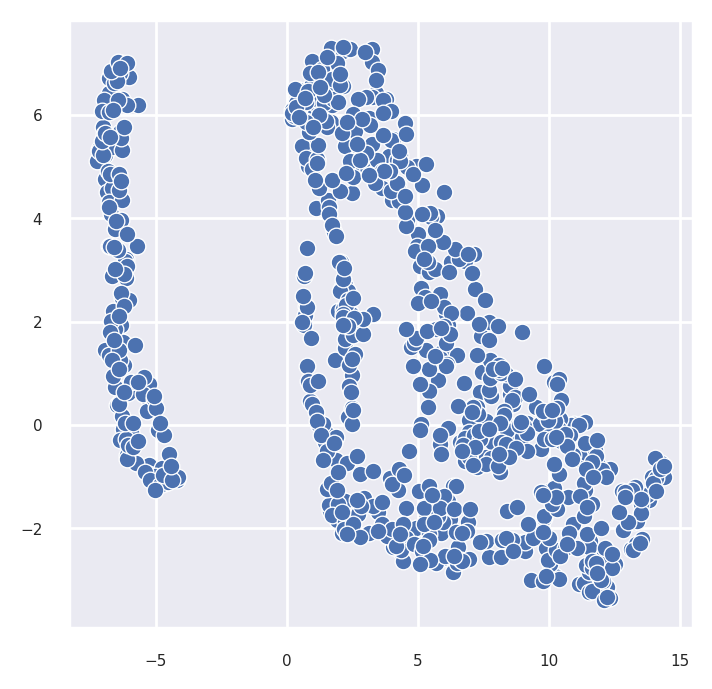

In [278]:
umap_x = mc.ut.get_o_numpy(metacells, 'umap_x')
umap_y = mc.ut.get_o_numpy(metacells, 'umap_y')
plot = sb.scatterplot(x=umap_x, y=umap_y)
plt.show()

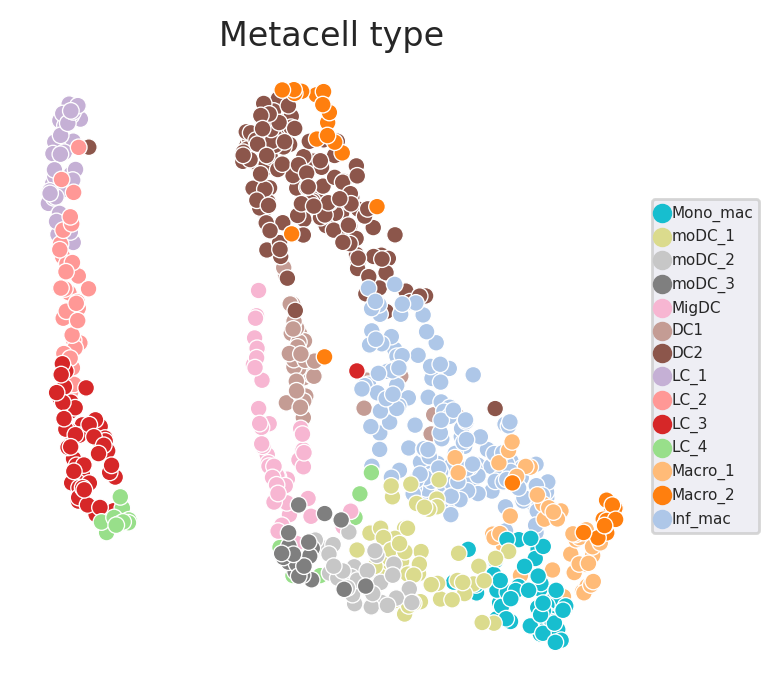

In [323]:
df_toplot = pd.DataFrame({'umap_x': umap_x, 
              'umap_y': umap_y, 
              'hue':metacells.obs['meta_type'].tolist()}).sort_values('hue')

ax = sb.scatterplot(data = df_toplot, x='umap_x', y='umap_y', hue = 'hue', 
                    hue_order = use_celltype,
                    palette= sb.color_palette("tab20_r", len(np.unique(metacells.obs['meta_type']))))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Metacell type', fontsize = 12)
ax.set_facecolor('white')
plt.show()

### 4.2.3 visualize the (skeleton) KNN graph on top of the UMAP

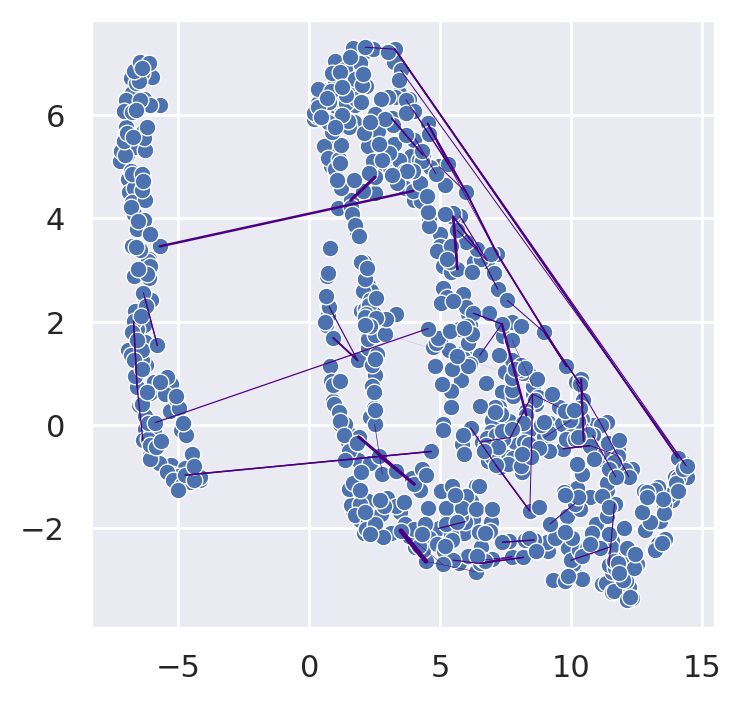

In [333]:
umap_edges = sp.coo_matrix(mc.ut.get_oo_proper(metacells, 'obs_outgoing_weights'))
min_long_edge_size = 1
sb.set()
plot = sb.scatterplot(x=umap_x, y=umap_y)
for (source_index, target_index, weight) \
        in zip(umap_edges.row, umap_edges.col, umap_edges.data):
    source_x = umap_x[source_index]
    target_x = umap_x[target_index]
    source_y = umap_y[source_index]
    target_y = umap_y[target_index]
    if hypot(target_x - source_x, target_y - source_y) >= min_long_edge_size:
        plt.plot([source_x, target_x], [source_y, target_y],
                 linewidth=weight * 2, color='indigo')
plt.show()

> Long edges indicate that UMAP did not capture this skeleton KNN graph well, or it might indicate that we are using some as features some “lateral” genes which are not relevant to the structure we are investigating.

### 4.2.4 Check some gene expression

In [290]:
def plot_gene_expression(gene):
    df_toplot = pd.DataFrame({'umap_x': umap_x, 
                  'umap_y': umap_y, 
                  'hue':metacells[:,gene].X.T[0].tolist()}).sort_values('hue')

    ax = sb.scatterplot(data = df_toplot, x='umap_x', y='umap_y', hue = 'hue',
                            palette= sb.color_palette("Blues", as_cmap=True))

    ax.get_legend().remove()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(gene, fontsize = 12)
    plt.show()

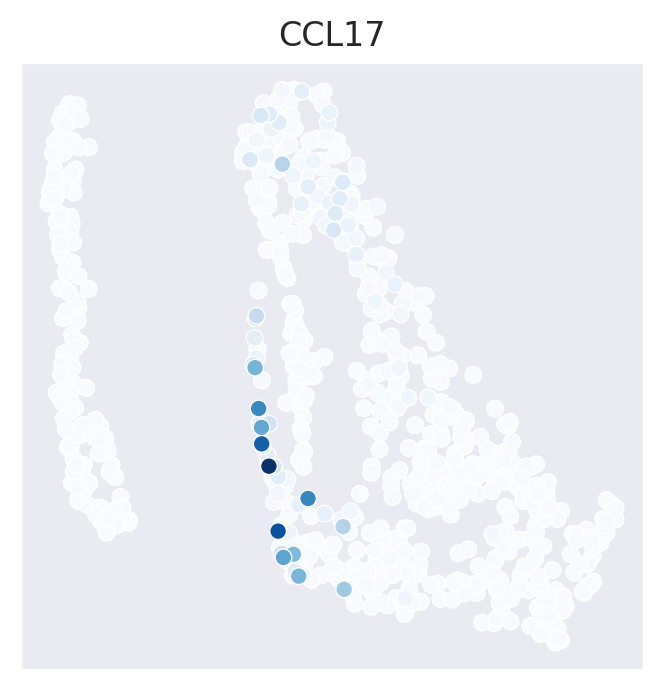

In [291]:
plot_gene_expression('CCL17')

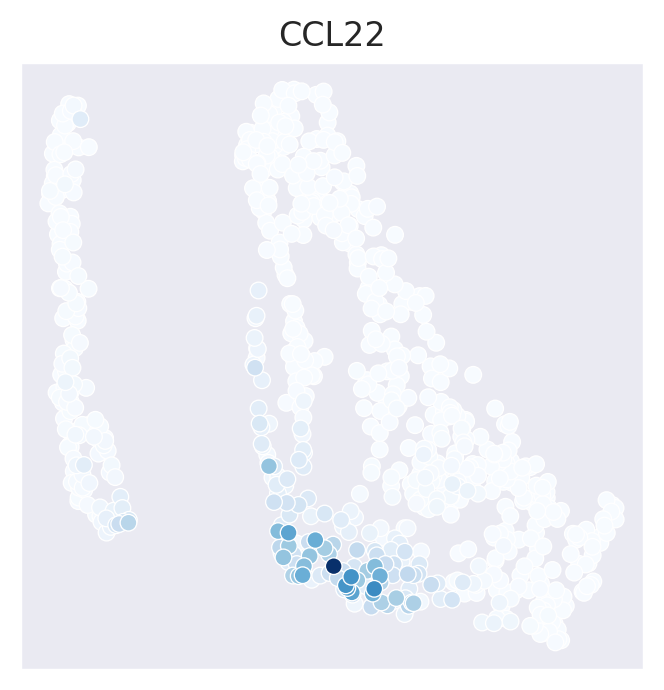

In [292]:
plot_gene_expression('CCL22')

### 4.2.5 Plot gene expression violin plot
* From the single-cell data (as opposed to metacells)

In [324]:
clean.obs['full_clustering'] = clean.obs['full_clustering'].cat.reorder_categories(use_celltype)

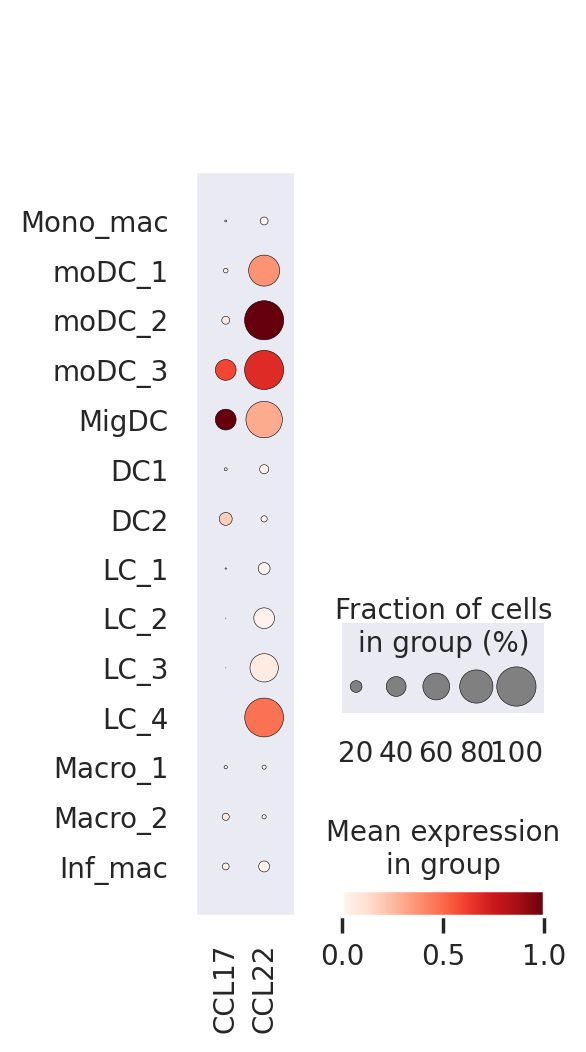

In [325]:
rcParams.update({'font.size': 12})
sc.pl.dotplot(clean, ['CCL17','CCL22'], 
              standard_scale = 'var', 
              groupby='full_clustering', 
              dendrogram=False, use_raw = False, expression_cutoff = 0)

# 5. Output

In [306]:
metacells_scaled = sc.pp.scale(metacells, copy = True)

In [307]:
# generate expression data frame
metacells_expr = pd.DataFrame(metacells_scaled.X)
metacells_expr.columns = metacells_scaled.var_names
metacells_expr.index = metacells_scaled.obs_names

# combine expression with metadata together
metacells_output = pd.concat([metacells_scaled.obs, metacells_expr], axis = 1)
metacells_output.index.name = 'ID'

In [308]:
metacells_output.to_csv('/mnt/code/Reynolds.myeloid.metacells.tsv', sep = '\t')

In [360]:
metacells.write('/mnt/data/SC-Reynolds-2021/metacells/metacells.AD.myeloid.h5ad')

... storing 'meta_type' as categorical


In [17]:
# metacells = ad.read_h5ad('/mnt/data/SC-Reynolds-2021/metacells/metacells.AD.myeloid.h5ad')

# 6. Single-cell processing (typicall normalization)

## 6.1. Normalization

In [334]:
def normalize_scran(adata):
    #Perform a clustering for scran normalization in clusters
    adata_pp = adata.copy()
    sc.pp.normalize_total(adata_pp, target_sum=1e6)
    sc.pp.log1p(adata_pp)
    sc.pp.pca(adata_pp, n_comps=30)
    
    # will use the above 30 PCs to compute neighbors
    sc.pp.neighbors(adata_pp)
    # umap here is for visaulization only
    sc.tl.umap(adata_pp)
    sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)
    
    #Preprocess variables for scran normalization
    input_groups = adata_pp.obs['groups']
    data_mat = adata.X.T.toarray()
    return (data_mat, input_groups)

In [335]:
data_mat, input_groups = normalize_scran(clean)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=30
    finished (0:00:19)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:01)


In [336]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = sizeFactors(computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters=input_groups, min.mean=0.1))

In [337]:
# Normalize adata
clean.obs['size_factors'] = size_factors
clean.layers["counts"] = clean.X.copy()
clean.X = np.array(clean.X / clean.obs['size_factors'].values[:,None])
sc.pp.log1p(clean)

In [338]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
clean.raw = clean

In [339]:
# ComBat batch correction (why is there divived by 0 warning?)
sc.pp.combat(clean, key='sample_id')

Standardizing Data across genes.

Found 10 batches

Found 0 numerical variables:
	

Found 53 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments



/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data



## 6.2 Typical clustering

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


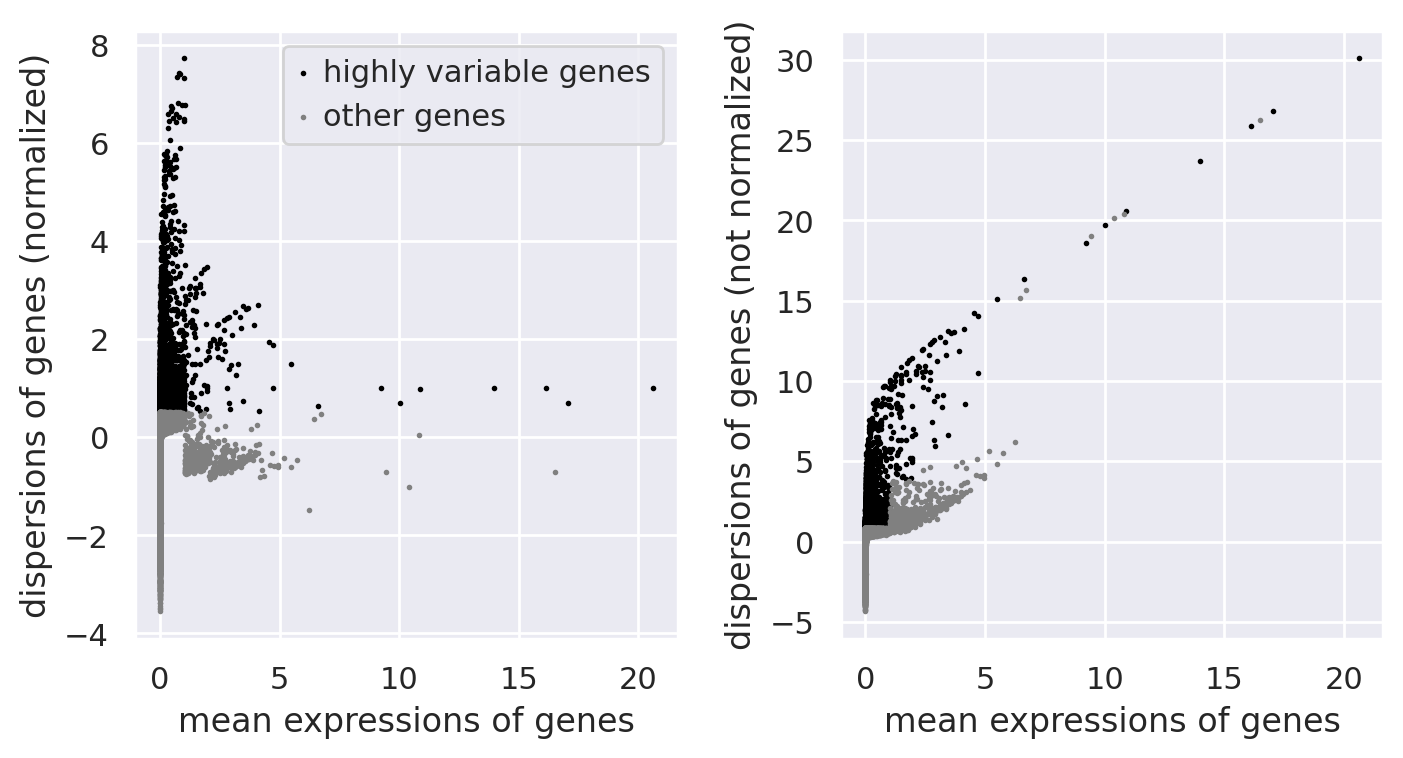

In [341]:
sc.pp.highly_variable_genes(clean, flavor='seurat', n_top_genes=4000)
sc.pl.highly_variable_genes(clean)

In [342]:
# Calculate the visualizations
sc.pp.scale(clean)
sc.pp.pca(clean, n_comps=30)
sc.pp.neighbors(clean)
sc.tl.umap(clean, random_state= 0)

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


In [343]:
sc.tl.louvain(clean, resolution=0.5, key_added='louvain_r0.5', random_state=0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:01)


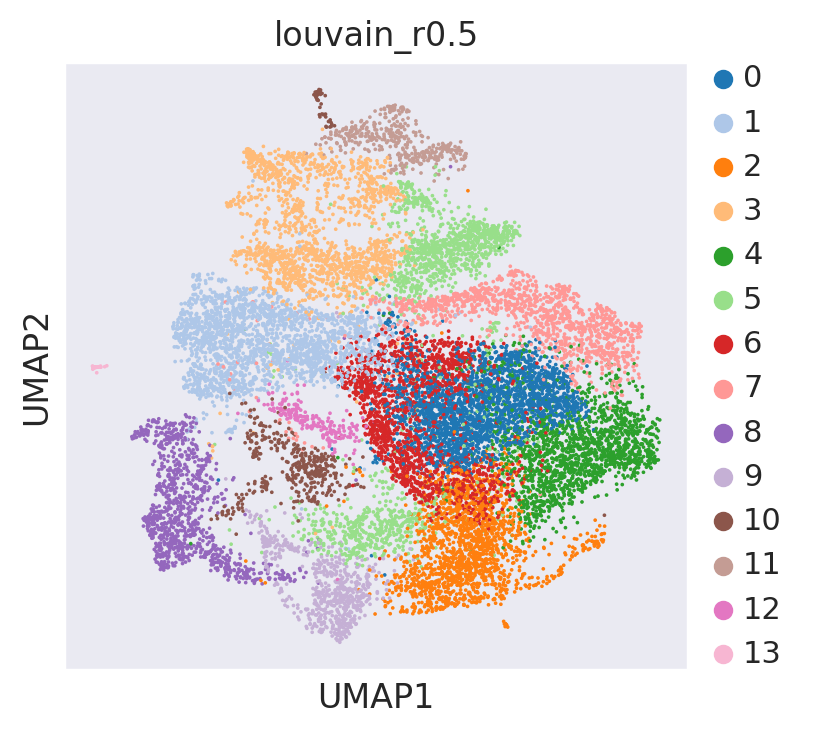

In [344]:
sc.pl.umap(clean, color='louvain_r0.5', palette=sc.pl.palettes.vega_20)

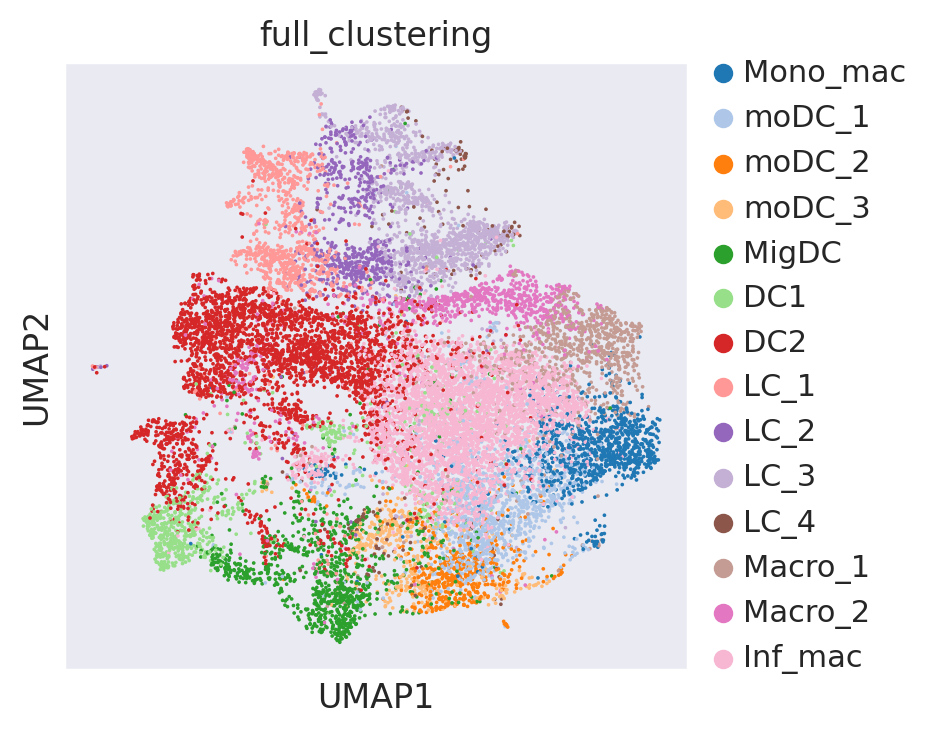

In [345]:
sc.pl.umap(clean, color='full_clustering', palette=sc.pl.palettes.vega_20)

In [359]:
clean.write('/mnt/data/SC-Reynolds-2021/metacells/clean.AD.myeloid.h5ad')

In [5]:
# clean = ad.read_h5ad('/mnt/data/SC-Reynolds-2021/metacells/clean.AD.myeloid.h5ad')

# 7. Downstream single-cell analysis

## 7.1 imputation

In [7]:
sc.external.pp.magic(clean, name_list='all_genes', knn=5)

computing MAGIC


/home/ubuntu/.local/lib/python3.8/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


  Running MAGIC with `solver='exact'` on 21911-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
    finished (0:01:49)


In [107]:
test1 = clean[:,'IL12B'].X.T[0].tolist()
test2 = clean[:,'IL23A'].X.T[0].tolist()

In [108]:
df_toplot = pd.DataFrame({'CCL17': test1, 
                  'CCL22': test2, 
                  'hue':clean.obs['full_clustering'].tolist()})

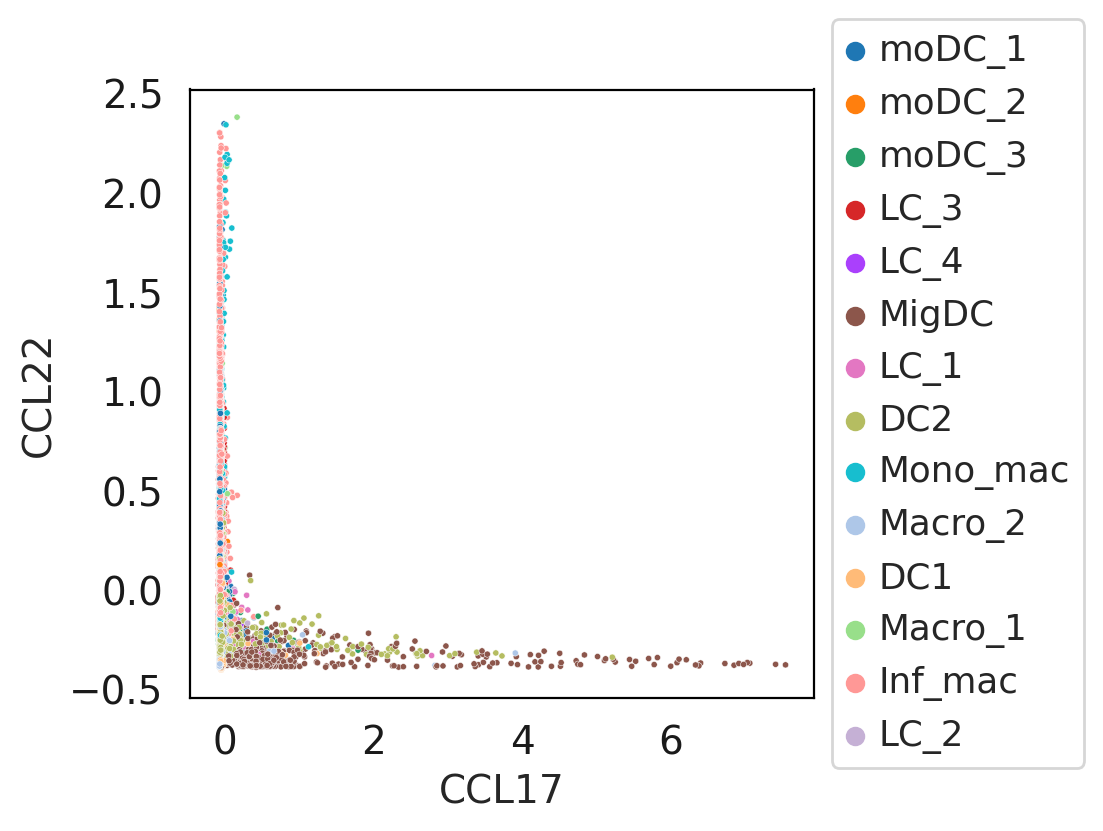

In [109]:
ax = sb.scatterplot(data = df_toplot, x='CCL17', y='CCL22', hue = 'hue',s = 5,)
ax.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [40]:
clean_select = clean[clean.obs['full_clustering'].isin(['moDC_1','moDC_2','moDC_3','MigDC','Mono_mac'])]

In [99]:
ccl17 = clean_select[:,'CCL17'].X.T[0].tolist()
ccl22 = clean_select[:,'CCL22'].X.T[0].tolist()

In [100]:
df_toplot = pd.DataFrame({'CCL17': ccl17, 
                  'CCL22': ccl22, 
                  'hue':clean_select.obs['full_clustering'].tolist()})

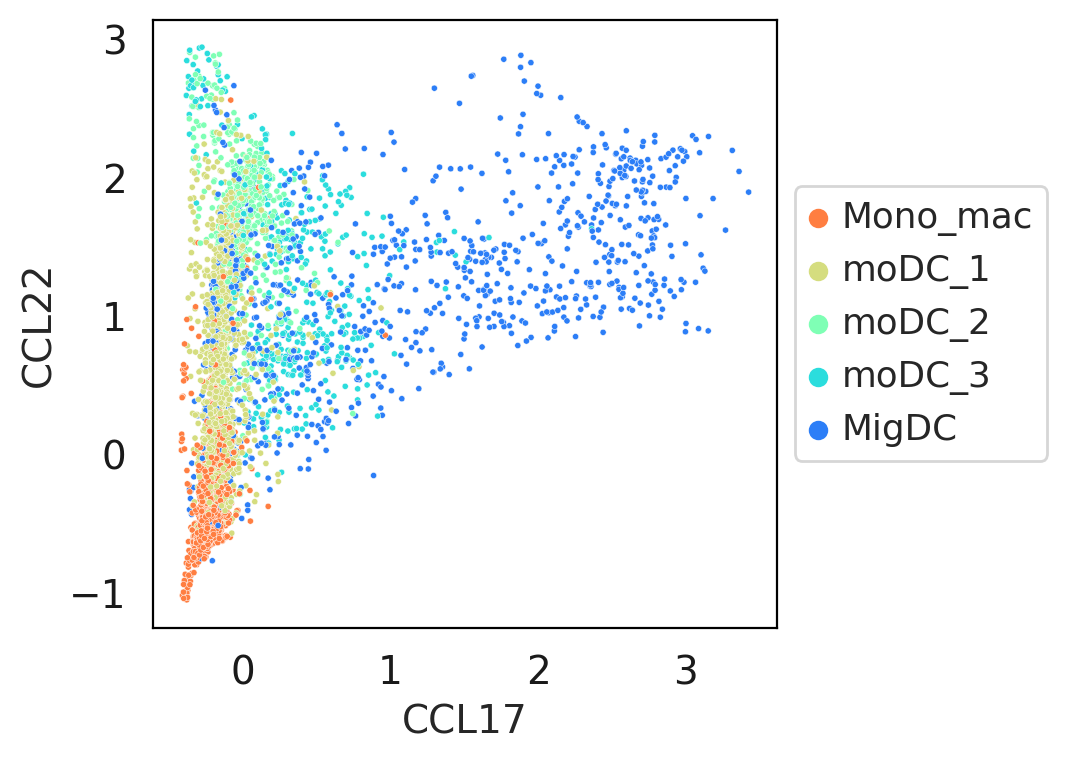

In [101]:
ax = sb.scatterplot(data = df_toplot, x='CCL17', y='CCL22', hue = 'hue',s = 5,
                    hue_order= ['Mono_mac','moDC_1','moDC_2','moDC_3','MigDC'],
                    palette= sb.color_palette("rainbow_r", 5))
ax.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

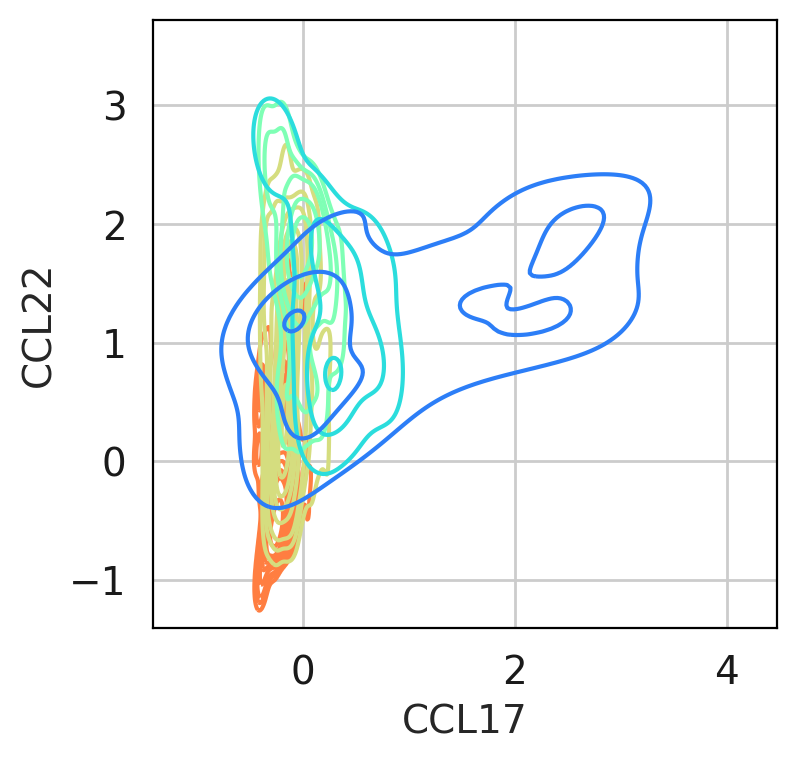

In [81]:
ax = sb.kdeplot(
    data=df_toplot, x="CCL17", y="CCL22", hue="hue", fill=False,
    hue_order = ['Mono_mac','moDC_1','moDC_2','moDC_3','MigDC'],
    palette= sb.color_palette("rainbow_r", 5)
)
ax.get_legend().remove()


In [441]:
clean_myeloid_use2 = clean_myeloid[clean_myeloid.obs['full_clustering'].isin(['moDC_1','moDC_2','moDC_3'])]


In [ ]:
sc.tl.rank_genes_groups(adata_AD_use, groupby='louvain_r0.5_Treg_sub', key_added='rank_genes_r0.5_Treg_sub')

In [447]:
sc.tl.rank_genes_groups(clean_myeloid_use, groupby='full_clustering', method = 'wilcoxon',
                        key_added='rank_genes_full', )

ranking genes
    finished: added to `.uns['rank_genes_full']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


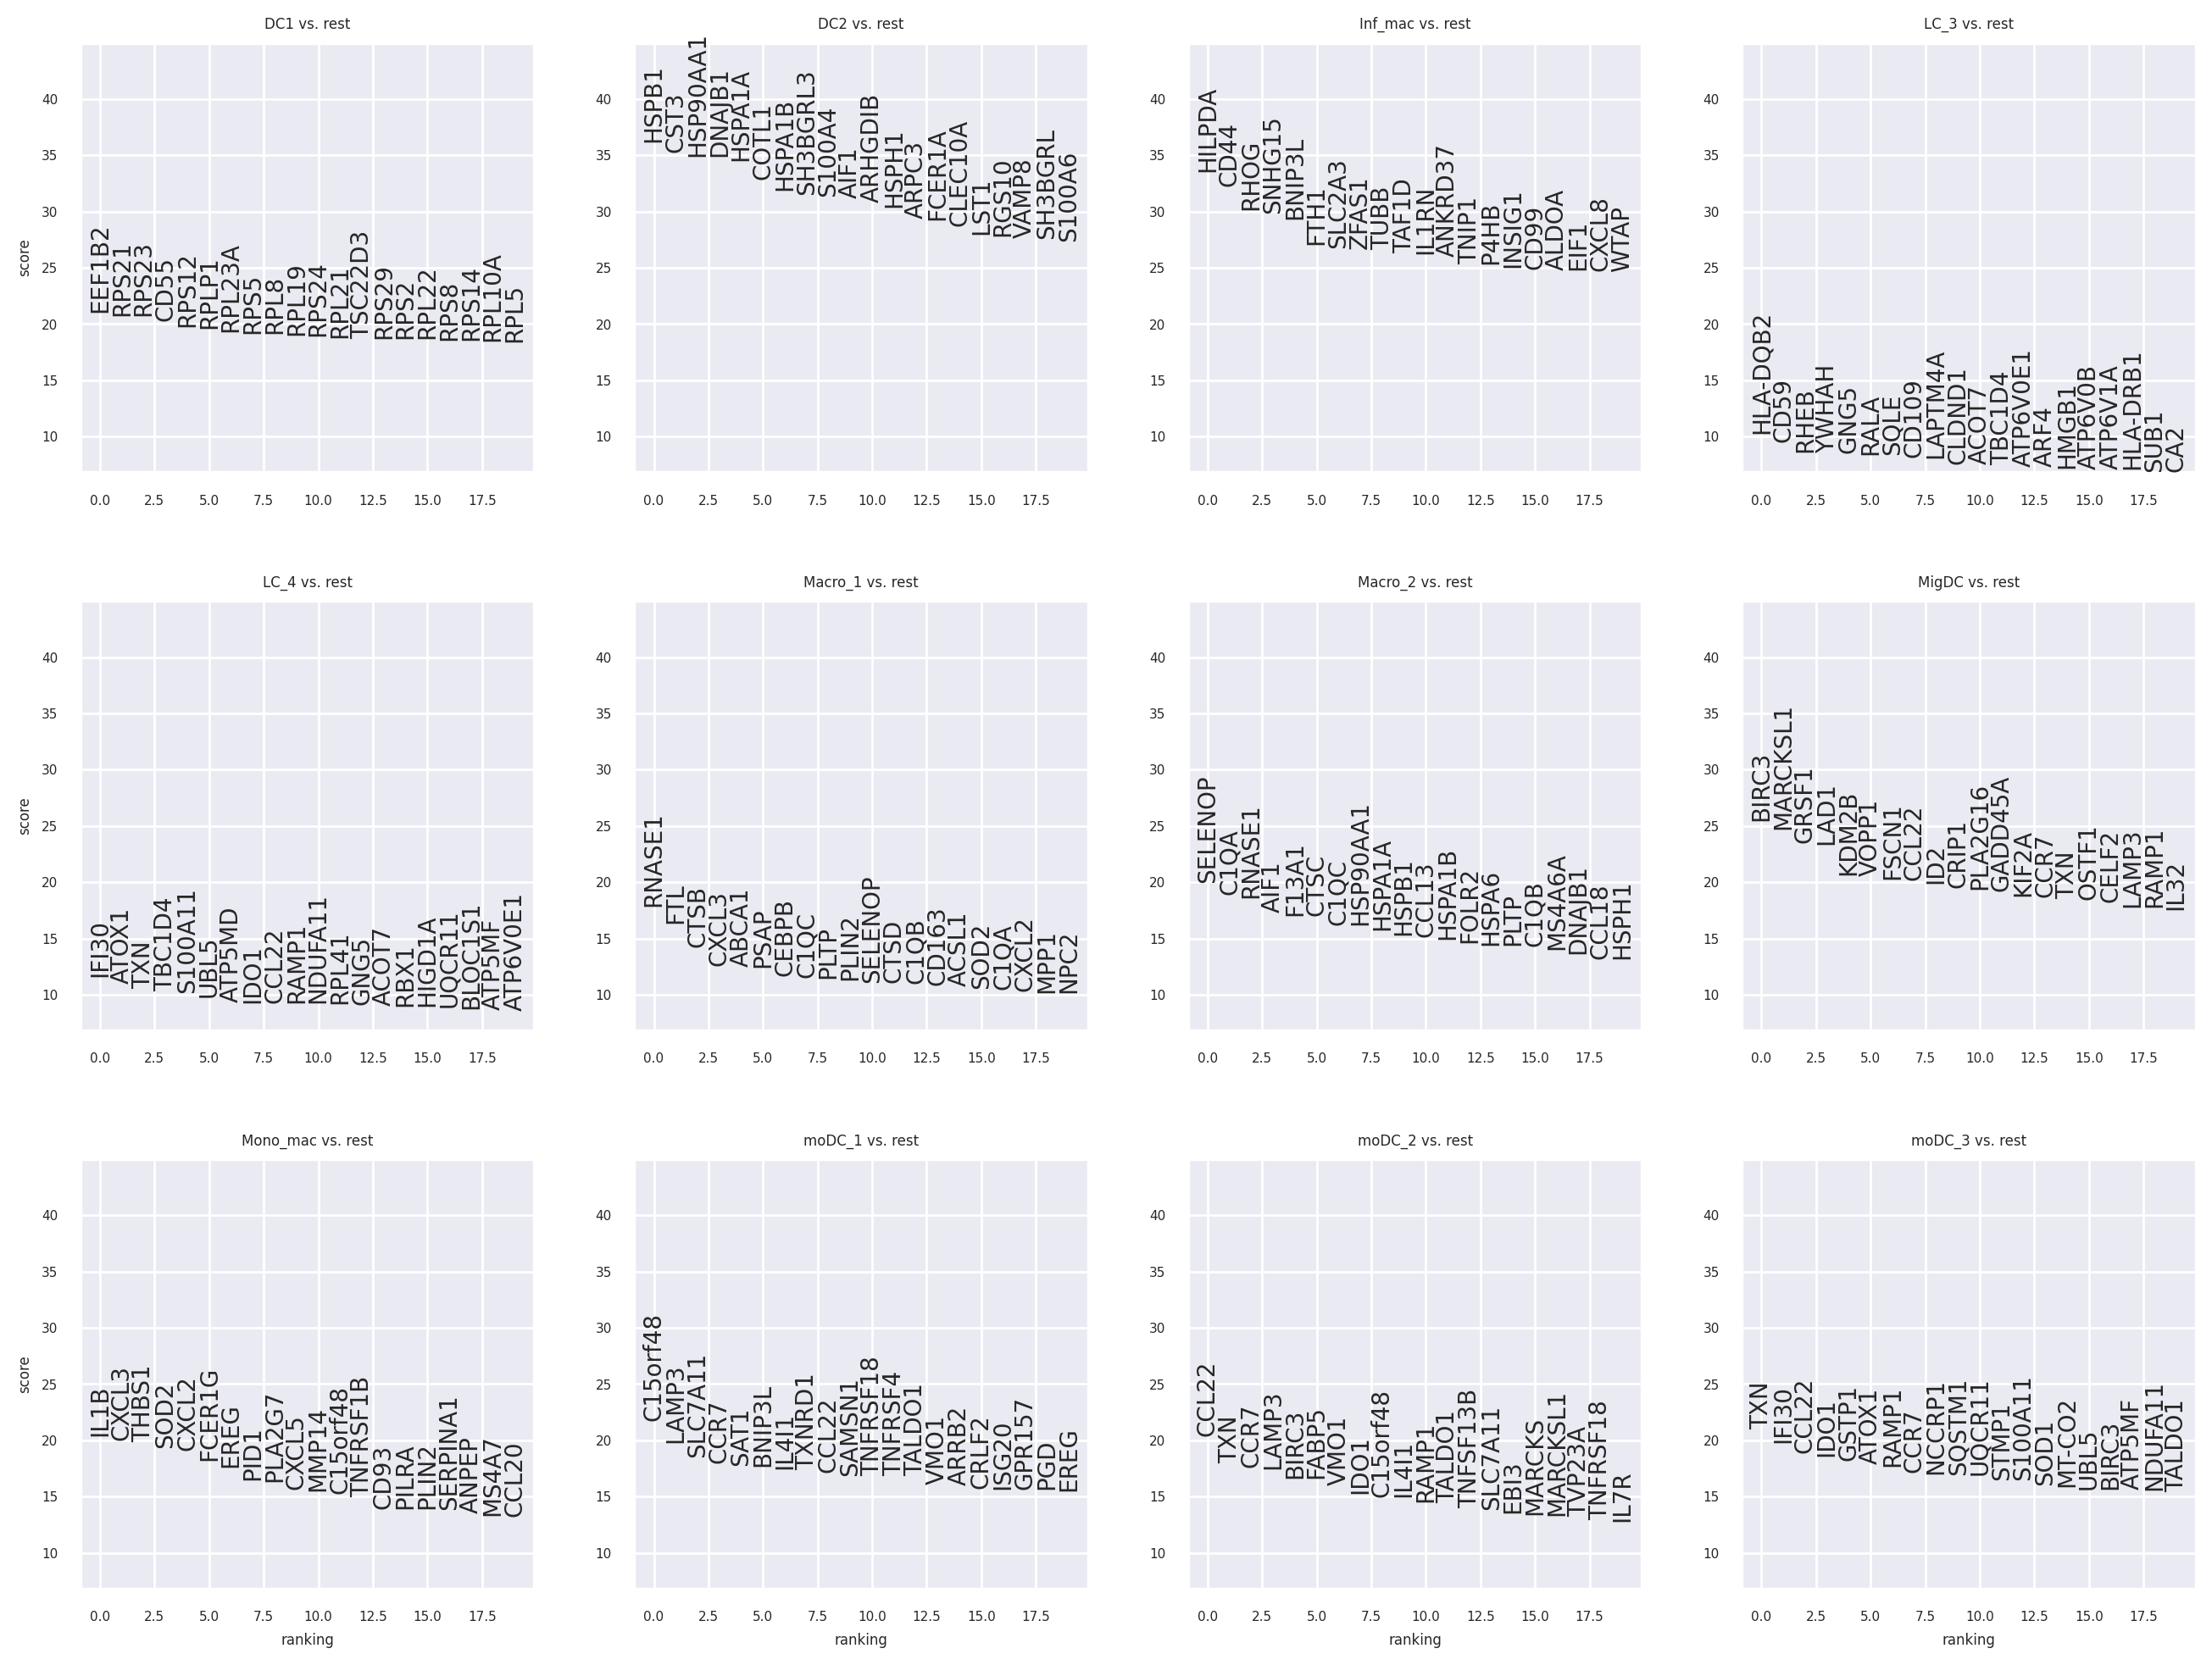

In [448]:
sc.pl.rank_genes_groups(clean_myeloid_use, key='rank_genes_full', fontsize=10)

In [299]:
metacells_scaled = sc.pp.scale(metacells, copy = True)

In [304]:
ccl17 = metacells_scaled[:,'CCL17'].X.T[0].tolist()
ccl22 = metacells_scaled[:,'CCL22'].X.T[0].tolist()

ax = sb.scatterplot(x=ccl17, y=ccl22, 
                        palette= sb.color_palette("Blues", as_cmap=True))

# ax.get_legend().remove()
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# plt.title('CCL17', fontsize = 12)

plt.show()

In [34]:
metacells.write('/mnt/data/SC-Reynolds-2021/metacells/metacells.h5ad')

# 5. Further analysis

> Further analysis methods are expected to create variable-sized groups of metacells with a similar “cell type” or gradients of metacells between such “cell types”, based on the gene programs they express. 

In [83]:
sc.external.pp.harmony_integrate(clean, 'sample_id')

2021-08-19 00:53:08,194 - harmonypy - INFO - Iteration 1 of 10
2021-08-19 00:53:09,912 - harmonypy - INFO - Iteration 2 of 10
2021-08-19 00:53:11,076 - harmonypy - INFO - Iteration 3 of 10
2021-08-19 00:53:12,236 - harmonypy - INFO - Iteration 4 of 10
2021-08-19 00:53:13,418 - harmonypy - INFO - Iteration 5 of 10
2021-08-19 00:53:14,585 - harmonypy - INFO - Iteration 6 of 10
2021-08-19 00:53:15,746 - harmonypy - INFO - Iteration 7 of 10
2021-08-19 00:53:16,640 - harmonypy - INFO - Iteration 8 of 10
2021-08-19 00:53:17,535 - harmonypy - INFO - Iteration 9 of 10
2021-08-19 00:53:18,426 - harmonypy - INFO - Iteration 10 of 10
2021-08-19 00:53:19,374 - harmonypy - INFO - Stopped before convergence


In [ ]:
sc.pp.neighbors(clean, )
sc.tl.umap(clean, random_state= 0)


In [80]:
clean

AnnData object with n_obs × n_vars = 5114 × 19254
    obs: 'sample_id', 'mad_prd', 'Status', 'Site', 'Tissue', 'Enrichment', 'Location', 'Sex', 'Age', 'stage', 'full_clustering', 'properly_sampled_cell', 'clean_cell', 'full_cell_index', 'size_factors', 'louvain_r0.5'
    var: 'properly_sampled_gene', 'excluded_gene', 'noisy_lonely_gene', 'clean_gene', 'full_gene_index', 'related_genes_module', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '__name__', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_r0.5_colors', 'sample_id_colors', 'full_clustering_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'
    varp: 'related_genes_similarity'